In [33]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
# import netCDF4
import geopandas as gpd
# from geopandas import GeoDataFrame
import cartopy.crs as ccrs
import datetime
# import datetime as dt
import glob
import os

In [2]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

## Import AmeriFlux

In [3]:
# Import site metadata csv
ameriflux_ds = pd.read_csv('AmeriFlux-site-search-results-202410071335.tsv', sep='\t')
fluxnet = ameriflux_ds.loc[ameriflux_ds['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
fluxnet_sub = fluxnet[['Site ID', 'Longitude (degrees)', 'Latitude (degrees)', 'Years of AmeriFlux FLUXNET Data']] #drop unneeded columns

fluxnet_sub

,Site ID,Longitude (degrees),Latitude (degrees),Years of AmeriFlux FLUXNET Data
5,AR-TF1,-66.7335,-54.9733,"2016, 2017, 2018"
9,BR-CST,-38.3842,-7.9682,"2014, 2015"
18,BR-Npw,-56.4120,-16.4980,"2013, 2014, 2015, 2016, 2017"
25,CA-ARB,-83.9452,52.6950,"2011, 2012, 2013, 2014, 2015"
26,CA-ARF,-83.9550,52.7008,"2011, 2012, 2013, 2014, 2015"
...,...,...,...,...
664,US-xTR,-89.5857,45.4937,"2017, 2018, 2019, 2020, 2021"
665,US-xUK,-95.1921,39.0404,"2017, 2018, 2019, 2020, 2021"
666,US-xUN,-89.5373,46.2339,"2017, 2018, 2019, 2020, 2021"
667,US-xWD,-99.2414,47.1282,"2019, 2020, 2021"


In [4]:
# Select one site
site_ID =  'US-A32'
site_sel = fluxnet_sub.loc[fluxnet['Site ID'] == site_ID]
site_sel

,Site ID,Longitude (degrees),Latitude (degrees),Years of AmeriFlux FLUXNET Data
133,US-A32,-97.8198,36.8193,"2015, 2016, 2017"


In [5]:
site_lat = site_sel['Latitude (degrees)'].values
site_lon = site_sel['Longitude (degrees)'].values

In [6]:
year_start = site_sel['Years of AmeriFlux FLUXNET Data'].str.split(', ').str[0].values[0]
year_end = site_sel['Years of AmeriFlux FLUXNET Data'].str.split(', ').str[-1].values[0]
# print(year_start,year_end)

# site_filename = 'ameriflux-data/AMF_' + site_ID + '_FLUXNET_SUBSET_' + year_start + '-' + year_end +'*'
# print(site_filename)

In [7]:
# Import selected site half-hourly data (HH) Subset data
filepath = 'ameriflux-data/'
sel_file = get_single_match(filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_HH_*.csv')
sel_ds = pd.read_csv(sel_file)
sel_ds.head()

,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,SW_IN_POT,SW_IN_F,SW_IN_F_QC,LW_IN_F,LW_IN_F_QC,VPD_F,...,RECO_DT_VUT_REF,RECO_DT_VUT_25,RECO_DT_VUT_50,RECO_DT_VUT_75,GPP_DT_VUT_REF,GPP_DT_VUT_25,GPP_DT_VUT_50,GPP_DT_VUT_75,RECO_SR,RECO_SR_N
0,201501010000,201501010030,-7.999,2,0.0,0.0,2,248.110,2,0.158,...,2.90789,2.90789,2.95940,3.44903,0.0,0.0,0.0,0.0,-9999,-9999
1,201501010030,201501010100,-7.934,2,0.0,0.0,2,248.110,2,0.162,...,2.91442,2.91442,2.96605,3.45678,0.0,0.0,0.0,0.0,-9999,-9999
2,201501010100,201501010130,-7.869,2,0.0,0.0,2,255.560,2,0.165,...,2.92095,2.92095,2.97270,3.46452,0.0,0.0,0.0,0.0,-9999,-9999
3,201501010130,201501010200,-7.745,2,0.0,0.0,2,255.560,2,0.166,...,2.93338,2.93338,2.98534,3.47926,0.0,0.0,0.0,0.0,-9999,-9999
4,201501010200,201501010230,-7.620,2,0.0,0.0,2,269.092,2,0.167,...,2.94588,2.94588,2.99807,3.49409,0.0,0.0,0.0,0.0,-9999,-9999


In [8]:
# select subset of columns + create datetime index
sel_sub = sel_ds[['TIMESTAMP_START','TIMESTAMP_END', 'NEE_VUT_REF','NEE_VUT_REF_QC']]
sel_sub.index = pd.to_datetime(sel_sub['TIMESTAMP_START'],format='%Y%m%d%H%M')
sel_sub.index.names = ['time']

In [9]:
# resample to 3-hourly per MiCASA
sel_resample = sel_sub[['NEE_VUT_REF']].resample('3h').mean()
sel_resample

,NEE_VUT_REF
time,
2015-01-01 00:00:00,7.712932
2015-01-01 03:00:00,7.443640
2015-01-01 06:00:00,-4.679067
2015-01-01 09:00:00,-23.557717
2015-01-01 12:00:00,-22.284517
...,...
2017-12-31 09:00:00,-6.382185
2017-12-31 12:00:00,-11.408590
2017-12-31 15:00:00,-6.200275


## Import MiCASA files

In [10]:
# for year in range(int(year_start),int(year_end)+1):
#     year_str = str(year)
#     for month in range(1,13):
#         f_month = f"{month:02}"
#         filename = '*_3hrly_' + year_s
#         filepath = os.path.join(data_path,year_str, f_month)
#         print(filepath)
#     break

In [11]:
# Create a list of unique dates from the site
time = sel_resample.index
dates_unique = list({dt.date() for dt in time})
dates_unique.sort()
# len(dates_unique)

In [12]:
# loop over dates
data_path = 'micasa-data/daily-0.1deg-final/holding/3hrly/'
path_list = []

for date in dates_unique[:100]:
    f_year = str(date.year)
    f_month = f"{date.month:02}"
    filename = 'MiCASA_v1_flux_*' + date.strftime('%Y%m%d') + '.nc4'
    filepath = get_single_match(os.path.join(data_path,f_year,f_month,filename))
    path_list.append(filepath)

In [13]:
# path_list

In [14]:
ds = xr.open_mfdataset(path_list)['NEE']

In [63]:
print(site_lat, site_lon)
# ds_subset = ds.sel(lon=site_lon, lat=site_lat, method='nearest')
# ds_subset

[36.8193] [-97.8198]


In [81]:
# import hvplot.xarray
# import geoviews
# import warnings
# warnings.filterwarnings("ignore")
proj=ccrs.PlateCarree()

In [84]:
# subset region
min_lon, max_lon = -110, -85
min_lat, max_lat = 30, 50

ds_subset = ds.sel(lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
# ds_subset

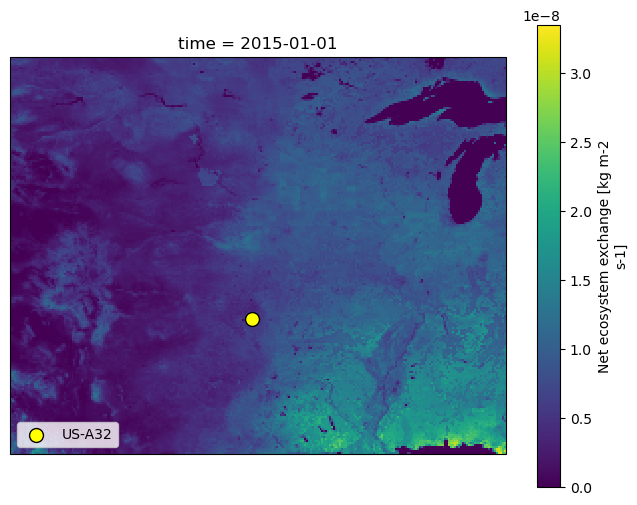

In [102]:
# Create a figure and plot background
fig, ax = plt.subplots(figsize=(8,6),subplot_kw= {'projection': proj});
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=proj);
ax.scatter(site_sel['Longitude (degrees)'],site_sel['Latitude (degrees)'],
           # marker='*', 
           s=100,
           color='yellow',
           edgecolor='black', zorder=3, label=f'{site_ID}')

# Add states??
# shape = '~/.local/share/cartopy/shapefiles/natural_earth/physical/ne_110m_land.shp'
# land = gpd.read_file(shape)
# land.plot(ax=ax,figsize=(10, 6),color='lightgrey')

ds_subset.isel(time=0).plot.pcolormesh(ax=ax)
ax.legend(loc='lower left')

In [ ]:
# vmin = -max(abs(ds_subset.min().values),abs(ds_subset.max().values))
# vmax = max(abs(ds_subset.min().values),abs(ds_subset.max().values))

# ds_subset.hvplot(cmap='seismic',groupby='time', clim=(vmin,vmax),
#              geo=True, 
#             projection=proj,
#             xlim=(min_lon, max_lon), 
#             ylim=(min_lat, max_lat),
#             # widget_type="scrubber", 
#             framewise=True,
#             widget_location="bottom",)